In [22]:
!pip install -q gdown inference-gpu

In [23]:
!pip list | grep supervision

supervision                              0.26.1


In [24]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

## ball, player, goalkeeper and referee detection

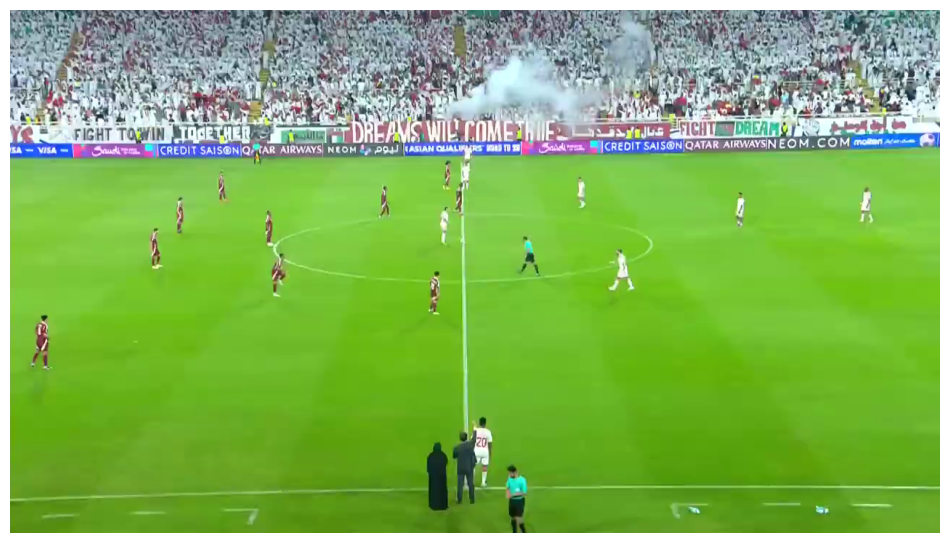

In [25]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

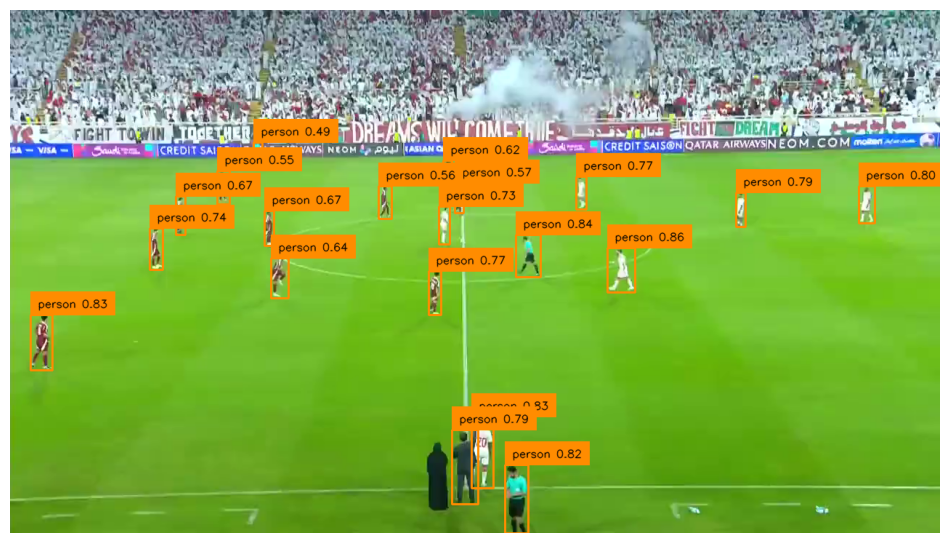

In [26]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

In [27]:
from inference import get_model

PLAYER_DETECTION_MODEL = get_model(model_id="yolov8x-640")

## video game style visualization

## player tracking

In [34]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"
PLAYER_ID = 0
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 25it [00:04,  5.29it/s]


**Note:** Here's a sample (100 elements) of the crops we've gathered.

In [32]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [35]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 13it [00:05,  2.47it/s]


**Note:** Using [UMAP](https://github.com/lmcinnes/umap), we project our embeddings from `(N, 768)` to `(N, 3)` and then perform a two-cluster division using [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [36]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [37]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

**Note:** Here's an interactive visualization of our results. Click on a dot to display its associated crop.

In [40]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

In [42]:
import supervision as sv

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

NameError: name 'FIELD_DETECTION_MODEL' is not defined

In [45]:
from inference import get_model

FIELD_DETECTION_MODEL = get_model(model_id="yolov8x-pose-640")

[10/26/25 18:50:20] ERROR    Unknown resize method, defaulting to 'Stretch to' - this may result in ]8;id=111948;file:///usr/local/lib/python3.12/dist-packages/inference/core/models/roboflow.py\roboflow.py]8;;\:]8;id=820502;file:///usr/local/lib/python3.12/dist-packages/inference/core/models/roboflow.py#484\484]8;;\
                             degraded model performance.                                                           

In [43]:
from inference import get_model

FIELD_DETECTION_MODEL = get_model(model_id="yolov8x-640")

## filter low confidence keypoints

In [47]:
import supervision as sv
import numpy as np

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# Add a check to see if key_points and its confidence are not None or empty
if key_points is not None and key_points.confidence is not None and len(key_points.confidence) > 0:
    filter = key_points.confidence[0] > 0.5
    if len(key_points.xy) > 0 and len(key_points.xy[0]) > 0:
        frame_reference_points = key_points.xy[0][filter]
        frame_reference_key_points = sv.KeyPoints(
            xy=frame_reference_points[np.newaxis, ...])

        annotated_frame = frame.copy()
        annotated_frame = vertex_annotator.annotate(
            scene=annotated_frame,
            key_points=frame_reference_key_points)

        sv.plot_image(annotated_frame)
    else:
        print("No keypoints detected after filtering.")
else:
    print("No keypoints detected in this frame.")

No keypoints detected in this frame.


In [49]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

TypeError: 'NoneType' object is not subscriptable

## project ball, players and referies on pitch

In [ ]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

In [ ]:
import cv2
from typing import Optional

def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

In [ ]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

## ball tracking

In [ ]:
from collections import deque
import supervision as sv
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "/content/CV_Task-1.mkv"
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)

In [ ]:
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [ ]:
from typing import List, Union

def replace_outliers_based_on_distance(
    positions: List[np.ndarray],
    distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            # If the current position is already empty, just add it to the cleaned positions
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                # If there's no valid last position, accept the first valid one
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                # Calculate the distance from the last valid position
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    # Replace with empty array if the distance exceeds the threshold
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions

In [ ]:
MAX_DISTANCE_THRESHOLD = 500

path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)